## CNN use pytorch in MNIST dataset

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
import torch.utils.data as data
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Download MNIST dataset in local system
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST (
   root = "data",              # 保存的位置
   train = True,               # this is training data 
   transform = ToTensor (),    # Converts a PIL.Image or numpy.ndarray to tensor  # 把灰階從 0~255 壓縮到 0~1
                               # torch.FloatTensor (C x H x W), 訓練的時候 normalize 成 [0, 1]區間
   download = True, 
) 
test_data = datasets.MNIST (
    root = "data",
    train = False,             # 不用 train
    transform = ToTensor ()
)

# split test dataset to test_data and val_data
val_data, test_data = data.random_split (test_data, [int (0.9 * len (test_data)), int (0.1 * len (test_data))])


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# print ("Training dataset size: ", len (train_data))
# print ("Validation dataset size: ", len (test_data))
# print ("Testing dataset size: ", len (val_data))


Training dataset size:  60000
Validation dataset size:  1000
Testing dataset size:  9000


In [5]:
# Preparing data for training with DataLoaders
loaders = {
    'train' : data.DataLoader (dataset = train_data,
                               batch_size = 100, 
                               shuffle = True, 
                               num_workers = 1),  # 表示開多少個thread個去運算數據
    
    'test'  : data.DataLoader (dataset = test_data, 
                               batch_size = 100, 
                               shuffle = True, 
                               num_workers = 1),
    'val'  : data.DataLoader (dataset = val_data, 
                               batch_size = 100, 
                               shuffle = True, 
                               num_workers = 1),
}

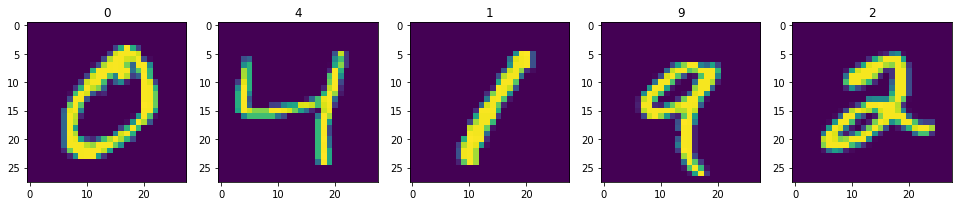

In [ ]:
# Visualize data
# fig= plt.figure (figsize=(20, 10))
# for i in range (1, 6) :
#     img = transforms .ToPILImage (mode = "L") (train_data [i][0])  # value
#     fig.add_subplot (1, 6, i)   # (row，col)
#     plt.title (train_data[i][1])  # index
#     plt.imshow (img)
# plt.show()

In [7]:
# Define the Convolutional Neural Network model
# Conv2d: Applies a 2D convolution over an input signal composed of several input planes.
class CNN (nn.Module) :
    def __init__ (self) :
        super (CNN, self).__init__()       # 調用了nn.Module.__init__()
        self.conv1 = nn.Sequential(        ## input shape (1, 28, 28)
            nn.Conv2d (                    # convolution filter
                in_channels = 1,           # input height   # gray
                out_channels = 16,         # n_filters      # extract 16 feature
                kernel_size = 5,           # filter size
                stride = 1,                # filter movement/step
                padding = 2,               # if want same width and length of this image after Conv2d, padding=(kernel_size-1)/2 if stride=1
            ),
            nn.ReLU (),                    ## output shape (16, 28, 28)
            nn.MaxPool2d (kernel_size = 2),# choose max value in 2x2 area, ## output shape (16, 14, 14)
            nn.BatchNorm2d (16, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True )
        )
        self.conv2 = nn.Sequential (       ## input shape (16, 14, 14)
            nn.Conv2d (16, 32 ,5 ,1 ,2),   ## output shape (32, 14, 14)
            nn.ReLU (),
            nn.MaxPool2d (2),              ## output shape (32, 7, 7)
            nn.BatchNorm2d (32, eps = 1e-5, momentum = 0.1, affine = True, track_running_stats = True ),
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear (32 * 7 * 7, 10)   #flatten

    # Pass defines the way we compute our output using the given layers and functions.
    def forward (self, x) :
        x = self.conv1 (x)
        x = self.conv2 (x)                 # (batch_size, 32 ,7 , 7)
        x = x.view (x.size (0), -1)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        pred = self.out (x)
        return pred

In [8]:
# net architecture
cnn = CNN ()
print (cnn) 

# Define loss function
criterion = nn.CrossEntropyLoss ()  # combines a softmax function nn.LogSoftmax() along with nn.NLLLoss() loss function.

# Define a Optimization Function
optimizer = torch.optim.SGD (cnn.parameters (), lr = 0.01)
print (optimizer)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [9]:
# Training and Valdiation
no_epochs = 50
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range (no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    # Training
    cnn.train()
    for itr, (image, label) in enumerate (loaders ['train']) :  # enumerate 把 load 進來的 data 列出來成（x, y）
        pred = cnn(image)                 # 計算預測值 
        loss = criterion (pred, label)    # cross entropy loss
        total_train_loss += loss.item()   # item(): 只包含一個元素的 tensor中提取值
        optimizer.zero_grad ()            # clear gradients for this training step
        loss.backward()                   # backpropagation, compute gradients
        optimizer.step()                  # apply gradients
        
    total_train_loss = total_train_loss / (itr + 1)
    # Record train loss
    train_loss.append(total_train_loss)

    # Validation
    cnn.eval()
    total = 0
    for itr, (image, label) in enumerate (loaders ['val']):
        pred = cnn (image)
        loss = criterion (pred, label)
        total_val_loss += loss.item ()
        pred = nn.functional.softmax (pred, dim = 1)  # 一維 # use softmax

        for i, p in enumerate (pred) :
            if label [i] == torch.max (p.data, 0)[1] :
                total = total + 1

    accuracy = total / len (val_data)

    total_val_loss = total_val_loss / (itr + 1)
    # Record validation loss
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format (epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))


Epoch: 1/50, Train Loss: 0.19670458, Val Loss: 0.08042762, Val Accuracy: 0.97833333

Epoch: 2/50, Train Loss: 0.07400516, Val Loss: 0.05690332, Val Accuracy: 0.98322222

Epoch: 3/50, Train Loss: 0.05548269, Val Loss: 0.04788195, Val Accuracy: 0.98588889

Epoch: 4/50, Train Loss: 0.04614924, Val Loss: 0.04161211, Val Accuracy: 0.98700000

Epoch: 5/50, Train Loss: 0.03975684, Val Loss: 0.03874188, Val Accuracy: 0.98777778

Epoch: 6/50, Train Loss: 0.03494553, Val Loss: 0.03757785, Val Accuracy: 0.98855556

Epoch: 7/50, Train Loss: 0.03139255, Val Loss: 0.03466039, Val Accuracy: 0.98833333

Epoch: 8/50, Train Loss: 0.02832782, Val Loss: 0.03548139, Val Accuracy: 0.98822222

Epoch: 9/50, Train Loss: 0.02577370, Val Loss: 0.03136929, Val Accuracy: 0.98988889

Epoch: 10/50, Train Loss: 0.02372688, Val Loss: 0.03072898, Val Accuracy: 0.98955556

Epoch: 11/50, Train Loss: 0.02178524, Val Loss: 0.02975199, Val Accuracy: 0.99100000

Epoch: 12/50, Train Loss: 0.02031662, Val Loss: 0.02964868, Va

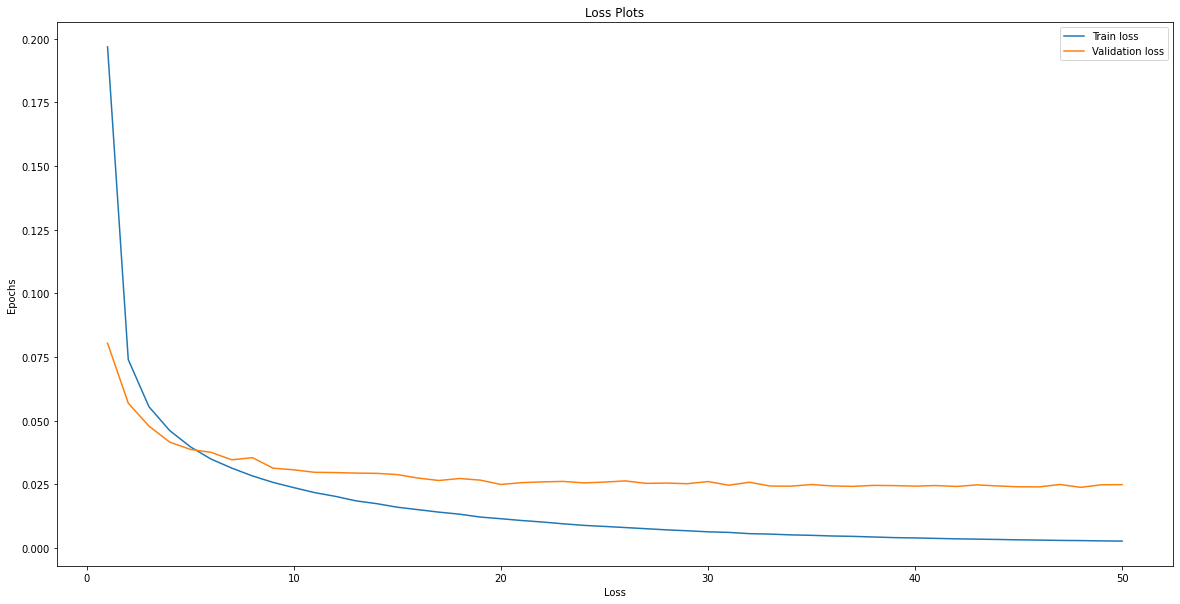

In [10]:
  # train and validation loss plot
fig = plt.figure (figsize = (20, 10))
plt.plot (np.arange (1, no_epochs + 1), train_loss, label = "Train loss")   # np.arange()支援步長為小數
plt.plot (np.arange (1, no_epochs + 1), val_loss, label= "Validation loss")
plt.xlabel ('Loss')
plt.ylabel ('Epochs')
plt.title ("Loss Plots")
plt.legend (loc = 'upper right')
plt.show ()

In [11]:
FILE = 'model_MNIST_CNN.pt'
torch.save(cnn, FILE)

In [12]:
# test model
model = torch.load('model_MNIST_CNN.pt')
cnn.eval()

results = list()
total = 0
for itr, (image, label) in enumerate((loaders ['test'])):

    pred = cnn(image)
    pred = torch.nn.functional.softmax(pred, dim=1)


    for i, p in enumerate(pred):
        if label[i] == torch.max(p.data, 0)[1]:
            total = total + 1
            results.append((image, torch.max(p.data, 0)[1]))

test_accuracy = total / (itr + 1)
print('Test accuracy: {:.8f}'.format(test_accuracy))

Test accuracy: 99.00000000


In [13]:
test_loss = 0.0
y_pred = [] 
cnn.eval()
for image, label in (loaders ['test']):
    output = cnn (image)
    loss = criterion (output, label)
    _, pred = torch.max (output, 1)
    y_pred.append (pred)
    test_loss += loss.item() * image.size(0)

print('Test Loss: {:.6f}'.format(test_loss/len(loaders ['test'].sampler)))

Test Loss: 0.033360


Text(0.5, 42.0, 'Predicted label')

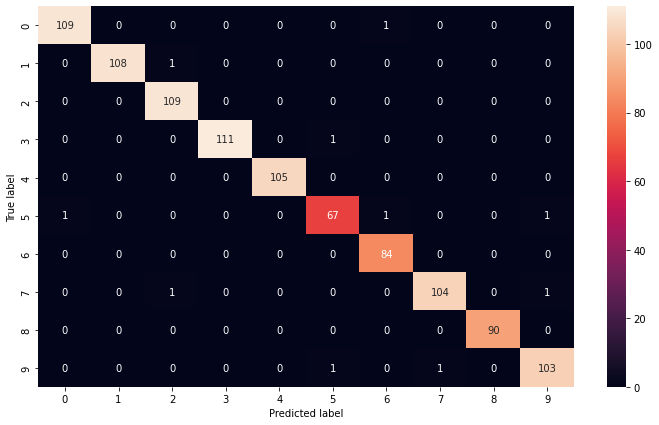

In [14]:
# Build confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in loaders ['test']:
        output = cnn(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True, fmt="d")
plt.ylabel("True label")
plt.xlabel("Predicted label")

n = 3


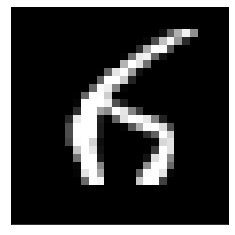

Inference label: 6
Ground truth label: 6
------------------------------
n = 8


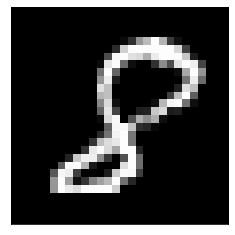

Inference label: 8
Ground truth label: 8
------------------------------
n = -1


In [15]:
# visualize results
def plot(a):
    a *= 255
    a = a.astype(np.uint8)
    return a.reshape(28, 28)

while True:
    print("n = ", end = '')
    n = int(input())
    if n == -1: break
    ax = plt.subplot()
    plt.imshow(plot(val_data[n][0].numpy()), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

    ### Print inference results corresponding to the image we plot
    prediction = model(val_data[n][0].reshape(1, 1, 28, 28))
    print("Inference label: {}".format(np.argmax(prediction.detach().numpy(), axis = 1)[0]))
    print("Ground truth label: {}".format(val_data[n][1], axis = 0)) 
    print('------------------------------')

## Reference

https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9